In [1]:
#!unzip -q '/content/data.zip'
#! pip install barbar

In [2]:
from __future__ import division
from __future__ import print_function

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
#from os import join
from time import time
import numpy as np  
import cv2 

from barbar import Bar
import pandas as pd
from time import time

# %run Utils.ipynb
# %run Visualize.ipynb
# %run Model.ipynb

import torch.nn as nn
import torch.nn.functional as F

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.cm import jet

import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

from scipy.optimize import minimize
from numpy import linalg as lin
from shapely.geometry import Polygon as P


os.makedirs('./output', exist_ok=True)

path = "/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking"

--------------**Uitility**-------------------

In [3]:
class Dataset(Dataset):

    def __init__(self, root_dir = 'data', folder="Train/" , kp_file = 'image_%05d_img', transform=None, length=5):
        self.root_dir = os.path.join(path, root_dir, folder)
        
        self.key_pts_file = os.path.join(self.root_dir, kp_file)
        self.transform = transform
        
        files = os.listdir(self.root_dir)
        self.dataLen = int(len(files)/length)

    def __len__(self):
        return self.dataLen

    def __getitem__(self, idx):
        # ensure there aren't conflicting file pointers
        
        image = imageio.imread(os.path.join(self.root_dir, "{}.png".format(self.key_pts_file %idx)))
        if(image.shape[2] == 4):
                image = image[:,:,0:3]
        
        initialKPs = np.array(pd.read_csv(os.path.join(self.root_dir, "{}-ORB.txt".format(self.key_pts_file %idx)), header=None))
        initialKPs = np.c_[ initialKPs, np.ones(initialKPs.shape[0]) ]
        
        KPs = np.array(pd.read_csv(os.path.join(self.root_dir, "{}-GT.txt".format(self.key_pts_file %idx)), header=None))
        KPs = np.c_[ KPs, np.ones(KPs.shape[0]) ]
        
        image = Image.fromarray(image)
        
        bb = np.array(pd.read_csv(os.path.join(self.root_dir, "{}-BOUND.txt".format(self.key_pts_file %idx)), header=None)).ravel()
        
        item = {'image': image, 'original_image': np.asarray(image) ,'bb': bb, 'initial_keypoints' : initialKPs, 'keypoints': KPs}
        if self.transform is not None:
            item = self.transform(item)
        return item

#Transformations

def generate_heatmap(heatmap, pt, sigma):
    heatmap[int(pt[1])][int(pt[0])] = 1
    heatmap = cv2.GaussianBlur(heatmap, sigma, 0)
    am = np.amax(heatmap)
    heatmap /= am
    return heatmap

def render_onehot_heatmap(coord, input_shape,output_shape):
        #print(coord.shape)
        num_kps = 18
        batch_size = 1

        x = np.reshape(coord[:,0] / input_shape[1] * output_shape[1],[-1])
        y = np.reshape(coord[:,1] / input_shape[0] * output_shape[0],[-1])
        x_floor = np.floor(x)
        y_floor = np.floor(y)

        x_floor = np.clip(x_floor, 0, output_shape[1] - 1)  # fix out-of-bounds x
        y_floor = np.clip(y_floor, 0, output_shape[0] - 1)  # fix out-of-bounds y
        #print("floor ", x_floor, y_floor)
        indices_batch = np.expand_dims(\
                np.reshape(\
                np.transpose(\
                np.tile(\
                np.expand_dims(np.arange(batch_size),0)\
                ,[num_kps,1])\
                ,[1,0])\
                ,[-1]).astype(float),1)
        #print("indices_batch" , indices_batch.shape)
        indices_batch = np.concatenate([indices_batch, indices_batch, indices_batch, indices_batch], axis=0)
        indices_joint = np.expand_dims(np.tile(np.arange(num_kps),[batch_size]),1).astype(float)
        indices_joint = np.concatenate([indices_joint, indices_joint, indices_joint, indices_joint], axis=0)
        #print("indices_joint" , indices_joint.shape)
        indices_lt = np.concatenate([np.expand_dims(y_floor-1,1), np.expand_dims(x_floor-1,1)], axis=1)
        indices_lb = np.concatenate([np.expand_dims(y_floor,1), np.expand_dims(x_floor-1,1)], axis=1)
        indices_rt = np.concatenate([np.expand_dims(y_floor-1,1), np.expand_dims(x_floor,1)], axis=1)
        indices_rb = np.concatenate([np.expand_dims(y_floor,1), np.expand_dims(x_floor,1)], axis=1)

        indices = np.concatenate([indices_lt, indices_lb, indices_rt, indices_rb], axis=0)
        #print("indices" , indices.shape, np.where(indices==64))
        indices = np.concatenate([indices_batch, indices, indices_joint], axis=1).astype(int)

        prob_lt = (1 - (x - x_floor)) * (1 - (y - y_floor))
        prob_lb = (1 - (x - x_floor)) * (y - y_floor)
        prob_rt = (x - x_floor) * (1 - (y - y_floor))
        prob_rb = (x - x_floor) * (y - y_floor)
        probs = np.concatenate([prob_lt, prob_lb, prob_rt, prob_rb], axis=0)

        heatmap = scatter_nd_numpy(indices, probs, (batch_size, *output_shape, num_kps))
        normalizer = np.reshape(np.sum(heatmap,axis=(1,2)),[batch_size,1,1,num_kps])
        normalizer = np.where(np.equal(normalizer,0),np.ones_like(normalizer),normalizer)
        heatmap = heatmap / normalizer
        
        return np.squeeze(heatmap) 
    
def scatter_nd_numpy(indices, updates, shape):
    target = np.zeros(shape, dtype=updates.dtype)
    indices = tuple(indices.reshape(-1, indices.shape[-1]).T)
    updates = updates.ravel()
    np.add.at(target, indices, updates)
    return target

def render_gaussian_heatmap(coord, output_shape, input_shape, sigma):
        
        x = [i for i in range(output_shape[1])]
        y = [i for i in range(output_shape[0])]
        xx,yy = np.meshgrid(y,x, indexing='ij')
        xx = np.reshape(xx, (*output_shape,1))
        yy = np.reshape(yy, (*output_shape,1))
        
        
        x = np.reshape(coord[:,0],[1,1,coord.shape[0]]) / input_shape[1] * output_shape[1]
        y = np.reshape(coord[:,1],[1,1,coord.shape[0]]) / input_shape[0] * output_shape[0]
        
        heatmap = np.exp(-(((xx-x)/np.float(sigma))**2)/np.float(2) -(((yy-y)/np.float(sigma))**2)/np.float(2))
        #print("heatmap.shape  ", heatmap.shape)
        return heatmap * 255.


def heatmaps_to_locs(heatmaps, outSize = (64, 64)):
    heatmaps = heatmaps.cpu().numpy()
    conf = np.max(heatmaps, axis=(-2,-1))
    locs = np.argmax(heatmaps.reshape((*heatmaps.shape[:2], -1)), axis=-1)
    locs = np.stack(np.unravel_index(locs, outSize)[::-1], axis=-1) # reverse x,y
    return torch.from_numpy(np.concatenate([locs, conf[..., None]], axis=-1).astype('float64'))


class CropAndPad:

    def __init__(self, out_size=(256,256)):
        self.out_size = out_size[::-1]

    def __call__(self, sample):
        image, bb = sample['image'], sample['bb']
       # img_size = image.size
        
        min_x,max_y,max_x,min_y = bb[0], bb[1], bb[2] , bb[3]
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2
        width, height = max_x-min_x, max_y-min_y
        ## Image crop works in a way (0, 0, 10, 10) but here the 
        ## image coordinates are revresed on Y-axis nd so the crop.
        sample['image'] = image.crop(box=(min_x,min_y,max_x,max_y))
        sample['orig_image'] = image
        sample['center'] = np.array([center_x, center_y], dtype=np.float32)
        sample['width'] = width
        sample['height'] = height
        
        w, h= self.out_size
        ## Crop and scale
        sample['crop'] = np.array([min_x, min_y], dtype=np.float32)
        sample['scale'] = np.array([w/width, h/height] , dtype=np.float32)
        
        if width != self.out_size[0]:
            sample['image'] = sample['image'].resize((w, h))
        if 'mask' in sample:
            sample['mask'] = sample['mask'].crop(box=(min_x,min_y,max_x,max_y)).resize((w, h))
        if 'keypoints' in sample:
            keypoints = sample['keypoints']
            for i in range(keypoints.shape[0]):
                if keypoints[i,0] < min_x or keypoints[i,0] > max_x or keypoints[i,1] < min_y or keypoints[i,1] > max_y:
                    keypoints[i,:] = [0,0,0]
                else:
                    keypoints[i,:2] = (keypoints[i,:2]-sample['crop'] )*sample['scale']
        sample['keypoints'] = keypoints
                    
        if 'initial_keypoints' in sample:
            initial_keypoints = sample['initial_keypoints']
            for i in range(initial_keypoints.shape[0]):
                if initial_keypoints[i,0] < min_x or initial_keypoints[i,0] > max_x \
                                or initial_keypoints[i,1] < min_y or initial_keypoints[i,1] > max_y:
                    initial_keypoints[i,:] = [0,0,0]
                else:
                    initial_keypoints[i,:2] = (initial_keypoints[i,:2]-sample['crop'] )*sample['scale']
        
        sample['initial_keypoints'] = initial_keypoints
        sample.pop('bb')
        return sample

# Convert keypoint locations to heatmaps
class LocsToHeatmaps:

    def __init__(self, img_size=(256,256), out_size=(64,64), sigma=1, algo : str=None):
        self.img_size = img_size
        self.out_size = out_size
        self.x_scale = 1.0 * out_size[0]/img_size[0]
        self.y_scale = 1.0 * img_size[0]/img_size[0]
        self.sigma=sigma
        x = np.arange(0, out_size[1], dtype=np.float)
        y = np.arange(0, out_size[0], dtype=np.float)
        self.yg, self.xg = np.meshgrid(y,x, indexing='ij')
        self.algo = algo
        
        return

    def __call__(self, sample):
        sigma = 7
        gaussian_hm = np.zeros((self.out_size[0], self.out_size[1], sample['keypoints'].shape[0]))
        if self.algo == 'PoseFix':
            gaussian_hm = render_onehot_heatmap(sample['keypoints'], self.img_size, self.out_size)
            #print(gaussian_hm.shape)
            #gaussian_hm = render_gaussian_heatmap(sample['keypoints'], self.img_size, self.img_size, sigma)
            #print(gaussian_hm.shape)
        else:
            for i,keypoint in enumerate(sample['keypoints']):
                if keypoint[2] != 0:
                    gaussian_hm[:,:,i] = generate_heatmap(gaussian_hm[:,:,i], tuple(keypoint.astype(np.int) * self.x_scale), (sigma, sigma))
        sample['keypoint_locs'] = sample['keypoints'][:,:2]
        sample['visible_keypoints'] = sample['keypoints'][:,2]
        sample['keypoint_heatmaps'] = gaussian_hm
        
        gaussian_hm_init = np.zeros((self.img_size[0], self.img_size[1], sample['initial_keypoints'].shape[0]))
        #print(" gaussian_hm_init   : ", gaussian_hm_init.shape)
        if self.algo == 'PoseFix':
            gaussian_hm_init = render_gaussian_heatmap(sample['keypoints'], self.img_size, self.img_size, sigma)
        else:
            for i,initial_keypoints in enumerate(sample['initial_keypoints']):
                if initial_keypoints[2] != 0:
                    gaussian_hm_init[:,:,i] = generate_heatmap(gaussian_hm_init[:,:,i], tuple(initial_keypoints.astype(np.int) * self.y_scale ), \
                                                               (sigma, sigma))
        sample['initial_keypoints_locs'] = sample['initial_keypoints'][:,:2]
        sample['visible_initial_keypoints'] = sample['initial_keypoints'][:,2]
        sample['initial_keypoints_heatmaps'] = gaussian_hm_init
        
        return sample

# Convert numpy arrays to Tensor objects
# Permute the image dimensions
class ToTensor:

    def __init__(self, downsample_mask=False):
        self.tt = transforms.ToTensor()
        self.downsample_mask=downsample_mask

    def __call__(self, sample):
        sample['image'] = self.tt(sample['image'])
        if 'orig_image' in sample:
            sample['orig_image'] = self.tt(sample['orig_image'])
        if 'mask' in sample:
            if self.downsample_mask:
                sample['mask'] = self.tt(sample['mask'].resize((64,64), Image.ANTIALIAS))
            else:
                sample['mask'] = self.tt(sample['mask'])
        if 'in_mask' in sample:
            sample['in_mask'] = self.tt(sample['in_mask'])
            # sample['in_mask'] = sample['in_mask'].unsqueeze(0)
        if 'keypoint_heatmaps' in sample:
            sample['keypoint_heatmaps'] =\
                torch.from_numpy(sample['keypoint_heatmaps'].astype(np.float32).transpose(2,0,1))
            sample['keypoint_locs'] =\
                torch.from_numpy(sample['keypoint_locs'].astype(np.float32))
            sample['visible_keypoints'] =\
                torch.from_numpy(sample['visible_keypoints'].astype(np.float32))
            
        if 'initial_keypoints_heatmaps' in sample:
            sample['initial_keypoints_heatmaps'] =\
                torch.from_numpy(sample['initial_keypoints_heatmaps'].astype(np.float32).transpose(2,0,1))
            sample['initial_keypoints_locs'] =\
                torch.from_numpy(sample['initial_keypoints_locs'].astype(np.float32))
            sample['visible_initial_keypoints'] =\
                torch.from_numpy(sample['visible_initial_keypoints'].astype(np.float32))
            
        return sample

class Normalize:

    def __call__(self, sample):
        sample['image'] = 2*(sample['image']-0.5)
        if 'in_mask' in sample:
            sample['in_mask'] = 2*(sample['in_mask']-0.5)
        return sample

------------------**Visualize**------------------

In [77]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

def show_all_keypoints(image, predicted_key_pts, gt_pts=None, fileName = None ,plot=False):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    
    if plot:
        plt.plot(predicted_key_pts[:, 0], predicted_key_pts[:, 1], c='m', label='Predicted')
        # plot ground truth points as green pts
        if gt_pts is not None:
            plt.plot(gt_pts[:, 0], gt_pts[:, 1], c='g', label='True')
    else:
        
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
        # plot ground truth points as green pts
        if gt_pts is not None:
            plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
    
    if fileName is not None:
        plt.savefig("./OutputKP/{}".format(fileName))
        
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(data, test_outputs, gt_pts=None ,batch_size=10, plot=False, savefig = False, algo=None):

    for i in range(0, batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, 1, 1)
        test_data = data[i]
        # un-transform the image data
        image = test_data['image']   # get the image from it's Variable wrapper

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = test_data['keypoints']
        
        file = '{}-Rescaled-Output{}.png'.format(i, "" if algo is None else algo) if savefig else None
        # call show_all_keypoints
        show_all_keypoints(image, predicted_key_pts, ground_truth_pts, fileName = file ,plot=plot)
        
        #print('RMS error for image %d is : %03f' %(i, np.sqrt(mean_squared_error(ground_truth_pts, predicted_key_pts))))
            
        #plt.axis('off')

    plt.show()
    
def visualize_test_output(test_images, test_outputs, gt_pts=None ,batch_size=10, plot=False, savefig = False, algo=None):

    for i in range(0, batch_size):
        plt.figure(figsize=(20,10))
        #ax = plt.subplot(i+1, 1, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
        
        file = '{}-Output{}.png'.format(i, "" if algo is None else algo) if savefig else None
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), np.squeeze(predicted_key_pts), np.squeeze(ground_truth_pts),fileName = file, plot=plot)
        
        #print('RMS error for image %d is : %03f' %(i, np.sqrt(mean_squared_error(ground_truth_pts, predicted_key_pts))))
            
        #plt.axis('off')

    plt.show()

def drawKeyPoints(num_to_display, dataSet):
    
    for i in range(num_to_display):

        # define the size of images
        fig = plt.figure(figsize=(20,10))

        plt.ion()
        # randomly select a sample
        rand_i = np.random.randint(0, len(dataSet))
        sample = dataSet[rand_i]

        # print the shape of the image and keypoints
        print(i, sample['image'].shape, sample['keypoints'].shape)

        ax = plt.subplot(1, num_to_display * 2, i + 1)
        ax.set_title('ORB Sample #{}'.format(i))
        
        plt.imshow(sample['orb_image'])
        
        ax = plt.subplot(1, num_to_display * 2, i + 2)
        ax.set_title('Sample #{}'.format(i))
        
        # Using the same display function, defined earlier
        show_keypoints(sample['image'], sample['keypoints'])
        

def plot_mesh(faces, verts, img, R, t, cameraMatrix, filename = None):
    fig, ax = plt.subplots()
    
    plt.imshow(img)
    verts_2d = np.matmul(cameraMatrix, np.matmul(R, verts.T) + t).T
    verts_2d = verts_2d[:,:2] / verts_2d[:,2, None]
    
    patches = []
    for face in faces:
        points = [verts_2d[i_vertex-1] for i_vertex in face]
        poly = Polygon(points, True)
        patches.append(poly)
        
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
    ax.add_collection(p)
    
    if fig is not None:
        plt.savefig("./output/{}".format(filename))
        
    plt.show()
        


---------------**MODEL**-----------------------

In [78]:
'''
Code is from https://github.com/bearpaw/pytorch-pose
Hourglass network inserted in the pre-activated Resnet
Use lr=0.01 for current version
(c) YANG, Wei
'''
__all__ = ['HourglassNet', 'hg']

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 2, kernel_size=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        #print("Bottleneck   ", out.shape)
        return out


class Hourglass(nn.Module):
    def __init__(self, block, num_blocks, planes, depth):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.block = block
        self.hg = self._make_hour_glass(block, num_blocks, planes, depth)

    def _make_residual(self, block, num_blocks, planes):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(planes*block.expansion, planes))
        return nn.Sequential(*layers)

    def _make_hour_glass(self, block, num_blocks, planes, depth):
        hg = []
        for i in range(depth):
            res = []
            for j in range(3):
                res.append(self._make_residual(block, num_blocks, planes))
            if i == 0:
                res.append(self._make_residual(block, num_blocks, planes))
            hg.append(nn.ModuleList(res))
        return nn.ModuleList(hg)

    def _hour_glass_forward(self, n, x):
        up1 = self.hg[n-1][0](x)
        low1 = F.max_pool2d(x, 2, stride=2)
        low1 = self.hg[n-1][1](low1)

        if n > 1:
            low2 = self._hour_glass_forward(n-1, low1)
        else:
            low2 = self.hg[n-1][3](low1)
        low3 = self.hg[n-1][2](low2)
        up2 = F.interpolate(low3, scale_factor=2)
        out = up1 + up2
        #print("Hourglass   ", out.shape)
        return out

    def forward(self, x):
        return self._hour_glass_forward(self.depth, x)


class HourglassNet(nn.Module):
    '''Hourglass model from Newell et al ECCV 2016'''
    def __init__(self, block, num_stacks=2, num_blocks=4, num_classes=16, ch_input = 21):
        super(HourglassNet, self).__init__()

        self.inplanes = 256
        self.num_feats = 256
        self.num_stacks = num_stacks
        self.conv1 = nn.Conv2d(ch_input, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=True)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_residual(block, self.inplanes, 1)
        self.layer2 = self._make_residual(block, self.inplanes, 1)
        self.layer3 = self._make_residual(block, self.num_feats, 1)
        #self.layer4 = self._make_residual(block, self.num_feats, 1)
        self.maxpool = nn.MaxPool2d(2, stride=2)

        # build hourglass modules
        ch = self.num_feats*block.expansion
        hg, res, fc, score, fc_, score_ = [], [], [], [], [], []
        for i in range(num_stacks):
            hg.append(Hourglass(block, num_blocks, self.num_feats, 4))
            res.append(self._make_residual(block, self.num_feats, num_blocks))
            fc.append(self._make_fc(ch, ch))
            score.append(nn.Conv2d(ch, num_classes, kernel_size=1, bias=True))
            if i < num_stacks-1:
                fc_.append(nn.Conv2d(ch, ch, kernel_size=1, bias=True))
                score_.append(nn.Conv2d(num_classes, ch, kernel_size=1, bias=True))
        self.hg = nn.ModuleList(hg)
        self.res = nn.ModuleList(res)
        self.fc = nn.ModuleList(fc)
        self.score = nn.ModuleList(score)
        self.fc_ = nn.ModuleList(fc_)
        self.score_ = nn.ModuleList(score_)

    def _make_residual(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_fc(self, inplanes, outplanes):
        bn = nn.BatchNorm2d(inplanes)
        conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=True)
        return nn.Sequential(
                conv,
                bn,
                self.relu,
            )

    def forward(self, x):
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        for i in range(self.num_stacks):
            y = self.hg[i](x)
            y = self.res[i](y)
            y = self.fc[i](y)
            score = self.score[i](y)
            out.append(score)
            if i < self.num_stacks-1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_
        return out


def hg(num_stacks=1, num_blocks=1, num_classes=10, ch_input=21):
    model = HourglassNet(Bottleneck, num_stacks=num_stacks, num_blocks=num_blocks, num_classes=num_classes, ch_input = ch_input)
    return model

In [79]:
class Rodrigues(torch.autograd.Function):
    @staticmethod
    def forward(self, inp):
        pose = inp.detach().cpu().numpy()
        rotm, part_jacob = cv2.Rodrigues(pose)
        self.jacob = torch.Tensor(np.transpose(part_jacob)).contiguous()
        rotation_matrix = torch.Tensor(rotm.ravel())
        return rotation_matrix.view(3,3)

    @staticmethod
    def backward(self, grad_output):
        grad_output = grad_output.view(1,-1)
        grad_input = torch.mm(grad_output, self.jacob)
        grad_input = grad_input.view(-1)
        return grad_input

rodrigues = Rodrigues.apply

def pose_optimization(faces, vertices, image, keypoints_2d, conf, keypoints_3d, K):
    # Send variables to GPU
    start = time()
    device = keypoints_2d.device
   
    keypoints_2d = torch.squeeze(keypoints_2d)
    
    K = K.to(device)
    r = torch.rand(3, requires_grad=True, device=device) # rotation in axis-angle representation
    t = torch.rand(3 ,requires_grad=True, device=device)
    d = conf.sqrt()[:, None]
    
    # 2D keypoints in normalized coordinates
    norm_keypoints_2d = torch.matmul(K.inverse(), \
                                     torch.cat((keypoints_2d, torch.ones(keypoints_2d.shape[0],1, device=device)), dim=-1).t()).t()[:,:-1]
    # set up optimizer
    optimizer = torch.optim.Adam([r,t], lr=1e-2)
    # converge check
    converged = False
    rel_tol = 1e-7
    loss_old = 100
    while not converged:
      optimizer.zero_grad()
      # convert axis-angle to rotation matrix
      R = rodrigues(r)
      # 1) Compute projected keypoints based on current estimate of R and t
      k3d = torch.matmul(R, keypoints_3d.transpose(1, 0)) + t[:, None]
      proj_keypoints = (k3d / k3d[2])[0:2,:].transpose(1,0) 
      # 2) Compute error (based on distance between projected keypoints and detected keypoints)
      err = torch.norm(((norm_keypoints_2d - proj_keypoints)*d)**2, 'fro')
      # 3) Update based on error
      err.backward()
      optimizer.step()
      # 4) Check for convergence
      if abs(err.detach() - loss_old)/loss_old < rel_tol:
        break
      else:
        loss_old = err.detach()    
        
    
    dataGT = norm_keypoints_2d.detach().cpu().numpy().astype(float)
    dataPnP = proj_keypoints.detach().cpu().numpy().astype(float)
    
    #print('torch norm ', torch.norm(((norm_keypoints_2d - proj_keypoints))**2, 'fro'))
    reprojection_error = torch.norm(((norm_keypoints_2d - proj_keypoints))**2, 'fro')
    ADD = lin.norm(dataGT - dataPnP)
    ADI = np.min([lin.norm(dataGT[i] - dataPnP[i]) for i in range(0, dataGT.shape[0])])
    ACPD = np.mean([lin.norm(dataGT[i] - dataPnP[i]) for i in range(0, dataGT.shape[0])])
    MCPD = np.max([lin.norm(dataGT[i] - dataPnP[i]) for i in range(0, dataGT.shape[0])])

    p1 = P(dataGT).buffer(0)
    p2 = P(dataPnP).buffer(0)
    #print(p1.is_valid, p2.is_valid)
    IOU = np.divide(p1.intersection(p2).area, p1.union(p2).area)


    R = rodrigues(r)
    plt.figure()
    plot_mesh(faces, vertices, image, R.detach().cpu().numpy(), t.detach().cpu().numpy()[:,None], K.detach().cpu().numpy(), fig='fig_{:.4f}'.format(ADD))
    plt.show()
    
    return ADD, ADI, ACPD, MCPD, IOU,reprojection_error, time()-start 

In [80]:

def pnp(faces, vertices, img, keypoints_2d, keypoints_3d, K, filename=None , flag=cv2.SOLVEPNP_ITERATIVE):
    
    #print(flag)
    start = time()
    device = keypoints_2d.device
    
    keypoints_3d = keypoints_3d.to(device)
    K = K.to(device)
    
    keypoints_2d = torch.squeeze(keypoints_2d)
    
    #print('KPs', KPs.detach().cpu().numpy().astype(float).shape)
    ret, rvecs, tvecs = cv2.solvePnP(keypoints_3d.detach().cpu().numpy().astype(float),\
                                     keypoints_2d.detach().cpu().numpy().astype(float),\
                                     K.detach().cpu().numpy().astype(float),\
                                     np.zeros((1,5)), flags = flag)
    
    r, part_jacob = cv2.Rodrigues(rvecs)
    t = tvecs
    
    norm_keypoints_2d = torch.matmul(K.inverse(), torch.cat((keypoints_2d, 
                                        torch.ones(keypoints_2d.shape[0],1, device=keypoints_2d.device)), dim=-1).t()).t()[:,:-1]
    
    #k3d = torch.matmul(K, torch.matmul(torch.Tensor(r), torch.FloatTensor(keypoints_3d).transpose(1, 0)) + torch.Tensor(t))
    k3d = torch.matmul(torch.Tensor(r), keypoints_3d.transpose(1, 0)) + torch.Tensor(t)
    
    proj_keypoints = (k3d / k3d[2])[0:2,:].transpose(1,0) 

    dataGT = norm_keypoints_2d.detach().cpu().numpy().astype(float)
    dataPnP = proj_keypoints.detach().cpu().numpy().astype(float)
    
    reprojection_error = torch.norm(((norm_keypoints_2d - proj_keypoints))**2, 'fro')
    ADD = lin.norm(dataGT - dataPnP)
    ADI = np.min([lin.norm(dataGT[i] - dataPnP[i]) for i in range(0, dataGT.shape[0])])
    ACPD = np.mean([lin.norm(dataGT[i] - dataPnP[i]) for i in range(0, dataGT.shape[0])])
    MCPD = np.max([lin.norm(dataGT[i] - dataPnP[i]) for i in range(0, dataGT.shape[0])])

    p1 = P(dataGT).buffer(0)
    p2 = P(dataPnP).buffer(0)
    IOU = np.divide(p1.intersection(p2).area, p1.union(p2).area)
    
    plt.figure(figsize=(15,10))
    #print(fig)
    plot_mesh(faces, vertices, img, r, t, K.detach().cpu().numpy(), filename = filename)
    plt.show()
    
    return ADD, ADI, ACPD, MCPD, IOU, reprojection_error, time()-start

In [81]:
class Trainer(object):

    def __init__(self, root_dir = 'data', num_classes = 18, batch_size = 1, length=6, algo = None):
        self.device = torch.device('cpu')
        #self.device = torch.cuda.current_device()
        torch.cuda.manual_seed(123)  # Set seed

        if algo == 'PoseFix':
          ch_input=21
        else:
          ch_input=3
        self.num_classes = num_classes
        self.model = hg(num_stacks=1, num_blocks=1, num_classes=self.num_classes, ch_input=ch_input) 

        self.model.to(self.device)
        
        # define loss function and optimizer
        self.algo = algo;
        #print("self.algo  : ", self.algo)
        if self.algo == 'PoseFix':
            train_transform_list = [CropAndPad(out_size=(256, 256)),LocsToHeatmaps(out_size=(64,64), algo = algo),ToTensor(),Normalize()]
            
            self.softmax = torch.nn.Softmax(dim=1)
            self.cross_entropy = torch.nn.CrossEntropyLoss().to(self.device)
            self.heatmap_loss = torch.nn.L1Loss().to(self.device)

            self.optimizer = torch.optim.Adam(self.model.parameters(),
                                                 lr = 2.5e-4)
        elif self.algo == 'SemanticKDD':
            train_transform_list = [CropAndPad(out_size=(256, 256)),LocsToHeatmaps(out_size=(64, 64), algo = algo),ToTensor(),Normalize()]
            
            self.heatmap_loss = torch.nn.MSELoss().to(self.device)
            self.optimizer = torch.optim.Adam(self.model.parameters(),
                                                 lr = 2.5e-4)
        else:
            train_transform_list = [CropAndPad(out_size=(256, 256)),LocsToHeatmaps(out_size=(64, 64), algo = algo),ToTensor(),Normalize()]
            
            self.heatmap_loss = torch.nn.MSELoss().to(self.device)
            self.optimizer = torch.optim.Adam(self.model.parameters(),
                                                 lr = 2.5e-4)
        
        self.train_ds = Dataset(root_dir=root_dir, transform=transforms.Compose(train_transform_list), length=length)
        self.train_data_loader = DataLoader(self.train_ds, batch_size=batch_size,
                                            num_workers=8,
                                            pin_memory=True,
                                            shuffle=True)

        self.summary_iters = []
        self.losses = []
        self.pcks = []

    def train(self, epochs = 400):
        
        self.total_step_count = 0
        start_time = time()
        for epoch in range(1, epochs + 1):

            running_loss = 0.0

            for step, batch in enumerate(self.train_data_loader):
              
                self.model.train()
                batch = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}

                self.optimizer.zero_grad()
                # print(batch['image'].shape, batch['keypoint_heatmaps'].shape, batch['initial_keypoints_heatmaps'].shape, \
                #       torch.cat([batch['image'], batch['initial_keypoints_heatmaps']], 1 ).shape)
                
                if self.algo == 'PoseFix':
                    pred_heatmap_list = self.model(torch.cat([batch['image'], batch['initial_keypoints_heatmaps']], 1 ).to(self.device))
                    kp_transpose = batch['keypoint_heatmaps'].transpose(1,2).transpose(2,3)
                    #print(kp_transpose[:,:,:, -1].shape, pred_heatmap_list[-1].long().shape)
                    cros_entropy_loss = self.cross_entropy(pred_heatmap_list[-1], kp_transpose[:,:,:, -1].long())
                    l1_loss = self.heatmap_loss(batch['keypoint_heatmaps'], pred_heatmap_list[-1])

                    loss = cros_entropy_loss + l1_loss    
                else:
                    pred_heatmap_list = self.model(batch['image'].to(self.device))
                    loss = self.heatmap_loss(batch['keypoint_heatmaps'], pred_heatmap_list[-1])
                                                       
                loss.backward()
                self.optimizer.step()                                          
                
                self.total_step_count += 1
                
                # print loss statistics
                running_loss += loss.item()
                if step % 10 == 0:    # print every 10 batches
                    print('Epoch: {}, Batch: {}, Total steps {} ,Avg. Loss: {}, time taken {}'.format(epoch, step+1, self.total_step_count, running_loss, time() - start_time))
                    running_loss = 0.0

        checkpoint_file = './output/model_checkpointv1.pt' if self.algo is None else './output/{}_model_checkpointv1.pt'.format(self.algo)
        checkpoint = {'model': self.model.state_dict()}
        print('saving model to ', checkpoint_file)
        torch.save(checkpoint, checkpoint_file)

In [88]:
class Tester(object):

    def __init__(self, root_dir = 'data', num_classes = 18, batch_size = 1, length=6, algo = None):
        self.device = torch.device('cpu')
        #self.device = torch.cuda.current_device()
        #torch.cuda.manual_seed(123)  # Set seed
        
        self.root_dir = root_dir
        self.num_classes = num_classes
        self.batch_size = batch_size
        
        test_transform_list = [CropAndPad(out_size=(256, 256)),LocsToHeatmaps(out_size=(64, 64), algo = algo),ToTensor(),Normalize()]
        self.test_ds = Dataset(root_dir=root_dir, folder="Test/", transform=transforms.Compose(test_transform_list), length=length)

        if algo == 'PoseFix':
          ch_input=21
        else:
          ch_input=3

        self.model = hg(num_stacks=1, num_blocks=1, num_classes=self.num_classes, ch_input=ch_input)
        self.model.to(self.device)
        # define loss function and optimizer
        self.test_data_loader = DataLoader(self.test_ds, batch_size=self.batch_size,
                                           pin_memory=True,
                                           shuffle=False)
        self.algo = algo
        if self.algo is not None:
            #file = './output/model_checkpoint.pt' if algo is None else './output/{}-model_checkpoint.pt'.format(self.algo)
            file ='./output/SemanticKDD_model_checkpoint-pandas.pt'
            print('fetching model from ', file)
        else:
            file = './output/model_checkpoint1.pt'
            print('fetching model from ', file)
            
        self.checkpoint = torch.load(file)
        self.model.load_state_dict(self.checkpoint['model'])

    def test(self, flag=None):
        
        centers = torch.zeros([len(self.test_ds), 2], dtype=torch.float32)
        crops = torch.zeros([len(self.test_ds), 2], dtype=torch.float32)
        scales = torch.zeros([len(self.test_ds), 2], dtype=torch.float32)
        predicted_heatmaps = np.zeros((len(self.test_ds), self.num_classes, 64, 64))
        #predicted_heatmaps = np.zeros((len(self.test_ds), self.num_classes,256,256))
        count = 0
        
        faces = pd.read_csv(os.path.join(path, self.root_dir, "GroundTruth/image_groundtruth_img-faces.txt"), header=None, sep=',').to_numpy().astype(int)
        vertices = pd.read_csv(os.path.join(path, self.root_dir, "GroundTruth/image_groundtruth_img-vertices.txt"), header=None, sep=',').to_numpy().astype(float)
        
        #scene = scene = pywavefront.Wavefront('/home/sourabh/Documents/TU-Berlin/Thesis/CADPictures/p8zmf1jsg5-PandaMale/PandaMale/PandaMale.obj', collect_faces = True)
        #vertices = np.array(scene.vertices)
        
        point3D = pd.read_csv(os.path.join(path, self.root_dir, "GroundTruth/3DPoints.txt"), header=None).to_numpy().astype(float)
        cameraMatrix = pd.read_csv(os.path.join(path, self.root_dir, "GroundTruth/CameraMatrix.txt"), header=None).to_numpy().astype(float)
        #print('vertices', vertices.shape)
        
        ADDError = []
        ADIError = []
        ACPDError = []
        MCPDError = []
        IOUs = []
        RPError = []
        tpnp = []
        
        ADDICPError = []
        ADIICPError = []
        ACPDICPError = []
        MCPDICPError = []
        IOUICPs = []
        RPICPError = []
        ticp = []
        
        start_time = time()
        errors = []
        for i, batch in enumerate(self.test_data_loader):
            self.model.eval()
            images = batch['image']
            
            centers[count:count+self.batch_size, :] = batch['center']
            crops[count:count+self.batch_size, :] = batch['crop']
            scales[count:count+self.batch_size, :] = batch['scale']
            with torch.no_grad():
                if self.algo == 'PoseFix':  
                  pred_heatmap_list = self.model(torch.cat([images, batch['initial_keypoints_heatmaps']], 1 ).to(self.device))
                else:
                  pred_heatmap_list = self.model(images.to(self.device))

            pred_heatmaps = pred_heatmap_list[-1]
            output_pts = heatmaps_to_locs(batch['keypoint_heatmaps'])
            
            output_pts = output_pts[:,:,:-1] * (256 / 64)
            output_pts = output_pts / batch['scale'][:,:].type(torch.DoubleTensor)
            output_pts = output_pts + batch['crop'][:,:].type(torch.DoubleTensor)
            
            image = batch['original_image'].data
            image = image.numpy()   
            image = np.squeeze(image)   # convert to numpy array from a Tensor
            
            if flag is not None:
                ADD, ADI, ACPD, MCPD, IOU,reprojection_error, t = pnp(faces, vertices, image , \
                                                                        output_pts.type(torch.FloatTensor),\
                                                                        torch.FloatTensor(point3D), torch.FloatTensor(cameraMatrix),\
                                                                      filename = '{}_{}.png'.format(flag, i), flag=flag)
            else:
                ADD, ADI, ACPD, MCPD, IOU,reprojection_error, t = pose_optimization(faces, vertices, image, \
                                                                                        torch.squeeze(output_pts[:,:,:-1]).type(torch.FloatTensor), \
                                                                                        torch.squeeze(output_pts[:,:,-1]).type(torch.FloatTensor),\
                                                                                        torch.FloatTensor(point3D), torch.FloatTensor(cameraMatrix))
           
            errors.append(torch.nn.MSELoss()(batch['keypoint_heatmaps'].to(self.device), pred_heatmaps).to(self.device))
            
            ADDError.append(ADD)
            ADIError.append(ADI)
            ACPDError.append(ACPD)
            MCPDError.append(MCPD)
            IOUs.append(IOU)
            RPError.append(reprojection_error.detach().cpu().numpy())
            tpnp.append(t)

            predicted_heatmaps[count:count+self.batch_size,:,:,:] = pred_heatmaps[0,:,:,:].cpu().numpy()
            
            count = count + self.batch_size 
    
        
        print('error {} , time taken {}'.format(torch.mean(torch.FloatTensor(errors)), time()-start_time))
        print('PnP ADD, ADI, ACPD, MCPD, Mean IOU , RPError {:.4f} {:.4f} {:.4f} {:.4f} {:.6f} {:.6f}'.format(np.mean(ADDError), np.mean(ADIError), np.min(ACPDError)\
                                                                 , np.min(MCPDError), np.mean(IOUs), np.mean(RPError)))
        
        keypoint_file = './output/detectionsv1.npy' if algo is None else './output/{}-detectionsv1.npy'.format(self.algo)
        print('Saving keypoints to ', keypoint_file)
        np.save(keypoint_file, predicted_heatmaps)
        
        return centers, crops, scales
        
    def test_net(self):
    
        # iterate through the test dataset
        for i, sample in enumerate(self.test_data_loader):

          # get sample data: images and ground truth keypoints
            self.model.eval()
            ori_images = sample['orig_image'] 
            images = sample['image'] 
            key_pts = sample['keypoints'] 

            with torch.no_grad():
                if self.algo == 'PoseFix':  
                  pred_heatmap_list = self.model(torch.cat([images, batch['initial_keypoints_heatmaps']], 1 ).cuda())
                else:
                  pred_heatmap_list = self.model(images.to(self.device))

            pred_heatmaps = pred_heatmap_list[-1]
            output_pts = heatmaps_to_locs(pred_heatmaps)
            #print('output_pts ', output_pts[:,:,:-1].size(), pred_heatmaps.size())
            # reshape to batch_size x 68 x 2 pts
            output_pts = output_pts.view(output_pts.size()[0], self.num_classes, -1)

            output_pts[:,:,:-1] *= 256 / 64

            # break after first image is tested
            if i == 0:
                return ori_images, images, output_pts[:,:,:-1], key_pts[:,:,:-1]

----------------**Train/Test**----------------

In [89]:
#algo = 'PoseFix'
algo='SemanticKDD'
#algo = None

In [90]:

# trainer = Trainer(algo = algo, batch_size = 2)
# trainer.train(epochs = 300)


fetching model from  ./output/SemanticKDD_model_checkpoint-pandas.pt


<Figure size 1080x720 with 0 Axes>

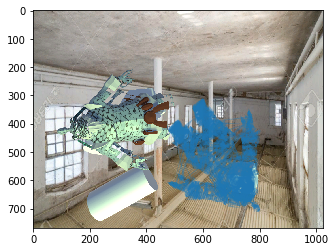

<Figure size 1080x720 with 0 Axes>

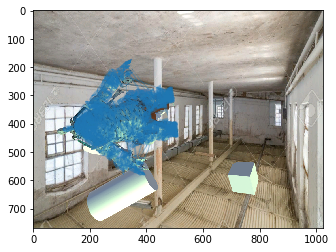

<Figure size 1080x720 with 0 Axes>

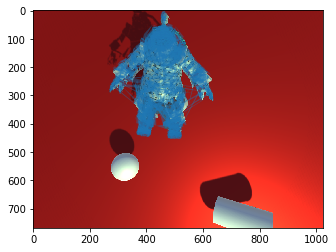

<Figure size 1080x720 with 0 Axes>

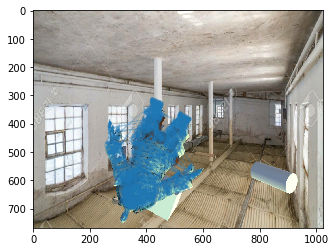

<Figure size 1080x720 with 0 Axes>

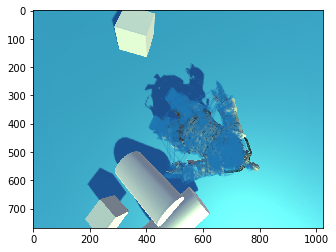

<Figure size 1080x720 with 0 Axes>

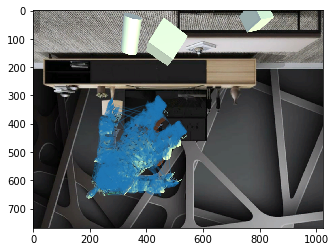

<Figure size 1080x720 with 0 Axes>

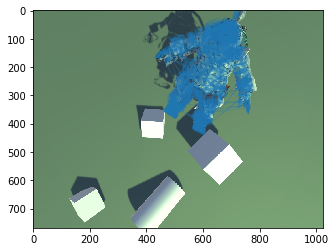

<Figure size 1080x720 with 0 Axes>

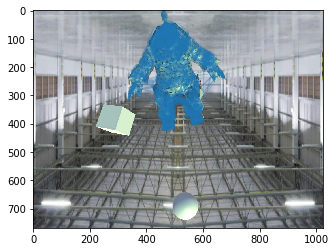

<Figure size 1080x720 with 0 Axes>

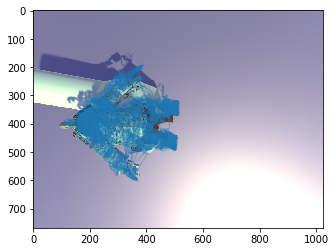

<Figure size 1080x720 with 0 Axes>

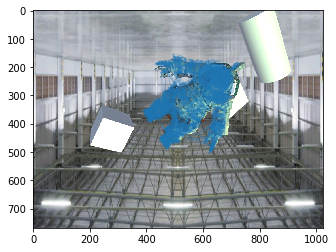

<Figure size 1080x720 with 0 Axes>

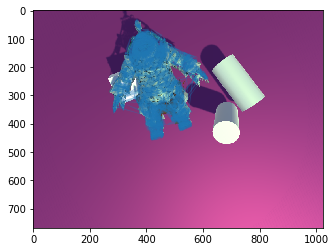

<Figure size 1080x720 with 0 Axes>

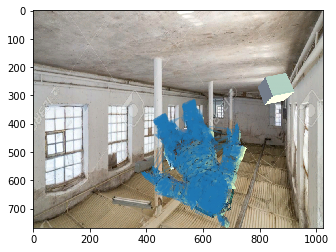

error 0.000508096010889858 , time taken 44.55677270889282
PnP ADD, ADI, ACPD, MCPD, Mean IOU , RPError 2723.5911 512.1962 472.8289 605.3255 0.000000 0.000185
Saving keypoints to  ./output/SemanticKDD-detectionsv1.npy


In [97]:
tester = Tester(root_dir='data/captures-panda', batch_size = 1, algo = algo)
centers, crops, scales = tester.test(flag=0)
# for t in [cv2.SOLVEPNP_ITERATIVE, cv2.SOLVEPNP_EPNP, cv2.SOLVEPNP_DLS]:
#     print('**********',t,'****************')
#     centers, crops, scales = tester.test(flag=t)
    
# centers, crops, scales = tester.test()

In [ ]:
detectedHMs = torch.from_numpy(np.load('./output/detectionsv1.npy' if algo is None else './output/{}-detectionsv1.npy'.format(algo)))
detectedKPs = heatmaps_to_locs(detectedHMs)
print(detectedKPs[:,:,:-1].size(), scales[:,None,:].size())
KPs = detectedKPs[:,:,:-1] * (256 / 64)
KPs = KPs / scales[:,None,:].type(torch.DoubleTensor)
KPs = KPs + crops[:,None,:].type(torch.DoubleTensor)

test_ds = Dataset(folder="captures-panda/Test/", transform=None, length=5)

visualize_output(test_ds, KPs, gt_pts=True, plot=True ,batch_size=10, savefig=True, algo=algo)

In [ ]:
oori_images,test_images, test_outputs, gt_pts = Tester(batch_size = 10, algo = algo).test_net()

##print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

visualize_test_output(test_images, test_outputs, gt_pts, plot=True ,batch_size=10, savefig=True, algo=algo)